In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import random
import glob
import collections
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [11]:
def abs_sobel_thresh(img, sobel_kernel=3, orient='x', thresh= (0,255)):

    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    sobel_mag = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return sxbinary


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output


def s_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    
    binary_output = np.zeros_like(s)
    binary_output[(s > thresh[0]) & (s <= thresh[1])] = 1
    return binary_output


def h_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h = hls[:,:,0]
    
    binary_output = np.zeros_like(h)
    binary_output[(h > thresh[0]) & (h <= thresh[1])] = 1
    return binary_output


def camera_calibrate(chessboard_size, open_path, save_path):
    i = chessboard_size[0]
    j = chessboard_size[1]
    objp = np.zeros((i*j,3), np.float32)
    objp[:,:2] = np.mgrid[0:i, 0:j].T.reshape(-1,2)

    objpoints = [] 
    imgpoints = [] 

    images = glob.glob(open_path) 
    count = 0 
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            write_name = save_path+'corners_found'+str(idx + 1)+'.jpg'
            cv2.imwrite(write_name, img)
        else:
            count += 1
    return objpoints, imgpoints

def undistort_img(img, objpoints, imgpoints):
    h, w = img.shape[:2]
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (w,h), None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

def perspective_trans(img):
    sizex = img.shape[0] # 720
    sizey = img.shape[1] # 1280
    src = np.float32([[588,470], [245,719], [1142, 719],[734,470]])
    dst = np.float32([[320,0], [320,720], [960, 720],[960,0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (sizey, sizex), flags=cv2.INTER_LINEAR)
    return {'warped':warped, 'dst':dst, 'src':src, 'Minv': Minv}

def region_of_interest(img, vertices):
    
    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def curvature_eval(binary_warped, nwindows = 20, margin = 50, minpix = 50):
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &\
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &\
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ym_per_pix = 30.0/720 
    xm_per_pix = 3.7/700 
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    y_eval = binary_warped.shape[0] - 1 
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    offset_val = xm_per_pix * 0.5 * (binary_warped.shape[1] - (leftx_base + rightx_base))
    
    if offset_val < 0:
        offset_dir = 'left'
    else:
        offset_dir = 'right'
    offset = {'offset_val':offset_val, 'offset_dir':offset_dir}
    
    return {'left_fit':left_fit,'right_fit':right_fit, 'nonzerox':nonzerox,'nonzeroy':nonzeroy,\
            'left_lane_inds':left_lane_inds,'right_lane_inds':right_lane_inds,\
            'left_curverad':left_curverad, 'right_curverad':right_curverad,\
            'right_fit_cr':right_fit_cr,'offset':offset, 'out_img':out_img }

def map_color(Minv, warped, undist, left_fitx, right_fitx, ploty):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

def map_curv(img, curvature, offset):
    font = cv2.FONT_HERSHEY_SIMPLEX;
    offset_val = offset['offset_val']
    offset_dir = offset['offset_dir']
    curv_text = 'Radius of curvature is: ' + str(curvature) + ' m' 
    offset_text = 'Car is offset: ' + str(abs(offset_val)) + ' m towards ' + offset_dir
    cv2.putText(img, curv_text, (50, 50), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(img, offset_text, (50, 100), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
    return img      

In [12]:
load_path = 'test_images/test' + str(random.randint(1,6)) + '.jpg'
img = mpimg.imread(load_path)
und_img = undistort_img(img, objpoints, imgpoints)
img = und_img
persp_obj = perspective_trans(img)
warped = persp_obj['warped']
dst = persp_obj['dst']
src = persp_obj['src']
Minv = persp_obj['Minv'] 


In [13]:
def process_img(img, M_inv=Minv, obj_points=objpoints, img_points=imgpoints, ksize=5, nwindows=40, margin=40, minpix=40):
    und_img = undistort_img(img, obj_points, img_points) 
    gradx = abs_sobel_thresh(und_img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(und_img, sobel_kernel=ksize, mag_thresh=(50, 100))
    s_binary = s_select(und_img, thresh=(150, 255))
    combined = np.zeros_like(gradx)
    combined[(((gradx == 1) & (mag_binary == 1))| (s_binary == 1))] = 1
    persp_obj = perspective_trans(combined)
    warped = persp_obj['warped']
    Minv = persp_obj['Minv']
    curv_obj = curvature_eval(warped, 40, 40, 40)
    left_fit = curv_obj['left_fit']
    right_fit = curv_obj['right_fit']
    left_lane_inds = curv_obj['left_lane_inds']
    right_lane_inds = curv_obj['right_lane_inds']
    offset = curv_obj['offset']
    left_curverad = curv_obj['left_curverad']
    right_curverad = curv_obj['right_curverad']
    curvature = 0.5 * (curv_obj['left_curverad'] + curv_obj['right_curverad'])
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    lane_img = map_color(M_inv, warped, und_img, left_fitx, right_fitx, ploty)
    lane_img = map_curv(lane_img, curvature, offset)
    return {'left_fit':left_fit, 'right_fit':right_fit, 'lane_img':lane_img, \
            'offset':offset, 'curvature':curvature, 'left_lane_inds':left_lane_inds,\
            'right_lane_inds':right_lane_inds, 'left_curverad':left_curverad,\
            'right_curverad':right_curverad, 'warped':warped, 'ploty':ploty, 'M_inv':M_inv, 'und_img':und_img}

In [16]:
def process_img(img, M_inv=Minv, obj_points=objpoints, img_points=imgpoints, ksize=5, nwindows=40, margin=40, minpix=40):
    und_img = undistort_img(img, obj_points, img_points) 
    gradx = abs_sobel_thresh(und_img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(und_img, sobel_kernel=ksize, mag_thresh=(50, 100))
    s_binary = s_select(und_img, thresh=(150, 255))
    combined = np.zeros_like(gradx)
    combined[(((gradx == 1) & (mag_binary == 1))| (s_binary == 1))] = 1
    persp_obj = perspective_trans(combined)
    warped = persp_obj['warped']
    Minv = persp_obj['Minv']
    curv_obj = curvature_eval(warped, 40, 40, 40)
    left_fit = curv_obj['left_fit']
    right_fit = curv_obj['right_fit']
    left_lane_inds = curv_obj['left_lane_inds']
    right_lane_inds = curv_obj['right_lane_inds']
    offset = curv_obj['offset']
    left_curverad = curv_obj['left_curverad']
    right_curverad = curv_obj['right_curverad']
    curvature = 0.5 * (curv_obj['left_curverad'] + curv_obj['right_curverad'])
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    lane_img = map_color(M_inv, warped, und_img, left_fitx, right_fitx, ploty)
    lane_img = map_curv(lane_img, curvature, offset)
    return {'left_fit':left_fit, 'right_fit':right_fit, 'lane_img':lane_img, \
            'offset':offset, 'curvature':curvature, 'left_lane_inds':left_lane_inds,\
            'right_lane_inds':right_lane_inds, 'left_curverad':left_curverad,\
            'right_curverad':right_curverad, 'warped':warped, 'ploty':ploty, 'M_inv':M_inv, 'und_img':und_img}

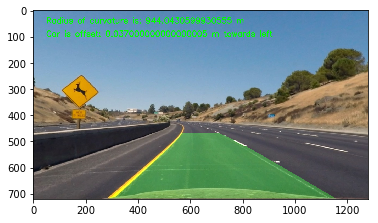

In [17]:
process_img_obj = process_img(img, Minv, objpoints, imgpoints, 5, 40, 40, 40)
plt.imshow(process_img_obj['lane_img'])

In [4]:
open_path = 'camera_cal/calibration*.jpg'
save_path = 'camera_cal/'
chessboard_size = [9, 6]
objpoints = []
imgpoints = []
objpoints, imgpoints = camera_calibrate(chessboard_size, open_path, save_path)

Text(0.5,1,'Undistorted Image')

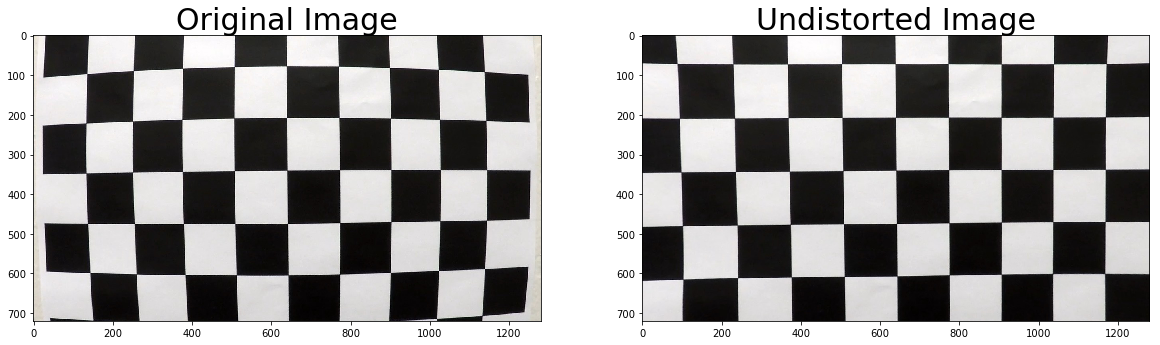

In [5]:
calib3_img = mpimg.imread('camera_cal/calibration1.jpg')
calib3_und_img = undistort_img(calib3_img, objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(calib3_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(calib3_und_img)
ax2.set_title('Undistorted Image', fontsize=30)